In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_only_conv_pool_3_ch_64_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=64, strides=1, 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=64*(2**int((i+1)/2)), strides=1, 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [9]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_64_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 64)         1664      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5326, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 340864)            0         
_________________________________________________________________
dropout (Dropout)            (None, 340864)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                5453840   
Total params: 5,455,504
Trainable params: 5,455,504
Non-trainable params: 0
___________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1332 - acc: 0.3353
Epoch 00001: val_loss improved from inf to 1.72919, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_64_DO_checkpoint/001-1.7292.hdf5
36805/36805 [==============================] - 25s 670us/sample - loss: 2.1331 - acc: 0.3353 - val_loss: 1.7292 - val_acc: 0.4873
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5244 - acc: 0.5354
Epoch 00002: val_loss improved from 1.72919 to 1.56103, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_64_DO_checkpoint/002-1.5610.hdf5
36805/36805 [==============================] - 23s 629us/sample - loss: 1.5244 - acc: 0.5354 - val_loss: 1.5610 - val_acc: 0.5171
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2840 - acc: 0.6093
Epoch 00003: val_loss improved from 1.56103 to 1.51867, s

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1954 - acc: 0.9550
Epoch 00028: val_loss did not improve from 1.50723
36805/36805 [==============================] - 23s 627us/sample - loss: 0.1954 - acc: 0.9550 - val_loss: 2.2335 - val_acc: 0.5222
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1885 - acc: 0.9563
Epoch 00029: val_loss did not improve from 1.50723
36805/36805 [==============================] - 23s 612us/sample - loss: 0.1886 - acc: 0.9563 - val_loss: 2.2797 - val_acc: 0.5188
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1775 - acc: 0.9613
Epoch 00030: val_loss did not improve from 1.50723
36805/36805 [==============================] - 23s 615us/sample - loss: 0.1774 - acc: 0.9613 - val_loss: 2.3016 - val_acc: 0.5190
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1677 - acc: 0.9640
Epoch 00031: val_loss did not improve from 1.50723
36805/36805 [=====

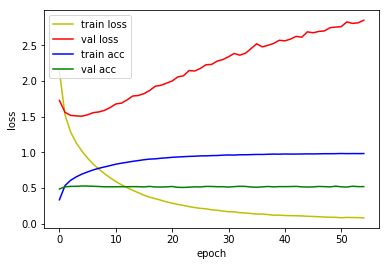

4815/4815 [==============================] - 1s 291us/sample - loss: 1.5735 - acc: 0.4962
Loss: 1.5735011094579567 Accuracy: 0.49615785

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9032 - acc: 0.3930
Epoch 00001: val_loss improved from inf to 1.45829, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_DO_checkpoint/001-1.4583.hdf5
36805/36805 [==============================] - 36s 984us/sample - loss: 1.9032 - acc: 0.3930 - val_loss: 1.4583 - val_acc: 0.5488
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3312 - acc: 0.5926
Epoch 00002: val_loss improved from 1.45829 to 1.22996, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_DO_checkpoint/002-1.2300.hdf5
36805/36805 [==============================] - 35s 957us/sample - loss: 1.3311 - acc: 0.5926 - val_loss: 1.2300 - val_acc: 0.6317
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9907
Epoch 00057: val_loss did not improve from 1.06901
36805/36805 [==============================] - 35s 957us/sample - loss: 0.0398 - acc: 0.9907 - val_loss: 1.7916 - val_acc: 0.7156

1D_CNN_2_only_conv_pool_3_ch_64_DO Model


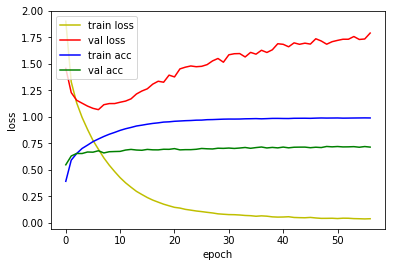

4815/4815 [==============================] - 2s 411us/sample - loss: 1.1811 - acc: 0.6486
Loss: 1.181147077645592 Accuracy: 0.64859813

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8807 - acc: 0.3924
Epoch 00001: val_loss improved from inf to 1.41539, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_DO_checkpoint/001-1.4154.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.8806 - acc: 0.3924 - val_loss: 1.4154 - val_acc: 0.5565
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2858 - acc: 0.6014
Epoch 00002: val_loss improved from 1.41539 to 1.13204, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_DO_checkpoint/002-1.1320.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.2858 - acc: 0.6014 - val_loss: 1.1320 - val_acc: 0.6546
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0553 - acc: 0.9849
Epoch 00027: val_loss did not improve from 0.58882
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0552 - acc: 0.9849 - val_loss: 0.8621 - val_acc: 0.8458
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9858
Epoch 00028: val_loss did not improve from 0.58882
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0535 - acc: 0.9858 - val_loss: 0.9124 - val_acc: 0.8355
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.9867
Epoch 00029: val_loss did not improve from 0.58882
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0492 - acc: 0.9867 - val_loss: 0.8548 - val_acc: 0.8437
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9867
Epoch 00030: val_loss did not improve from 0.58882
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9938
Epoch 00057: val_loss did not improve from 0.58882
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0264 - acc: 0.9938 - val_loss: 0.9986 - val_acc: 0.8498
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0224 - acc: 0.9952
Epoch 00058: val_loss did not improve from 0.58882
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0224 - acc: 0.9952 - val_loss: 1.0050 - val_acc: 0.8456
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9941
Epoch 00059: val_loss did not improve from 0.58882
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0267 - acc: 0.9941 - val_loss: 0.9983 - val_acc: 0.8437
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9933
Epoch 00060: val_loss did not improve from 0.58882
36805/36805 [===========

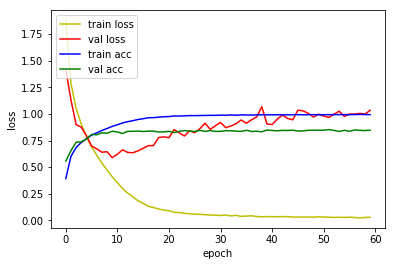

4815/4815 [==============================] - 2s 465us/sample - loss: 0.7394 - acc: 0.7958
Loss: 0.7393973096880214 Accuracy: 0.79584634

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9387 - acc: 0.3676
Epoch 00001: val_loss improved from inf to 1.28437, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_DO_checkpoint/001-1.2844.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.9386 - acc: 0.3676 - val_loss: 1.2844 - val_acc: 0.5868
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1956 - acc: 0.6374
Epoch 00002: val_loss improved from 1.28437 to 0.96718, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_DO_checkpoint/002-0.9672.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.1955 - acc: 0.6375 - val_loss: 0.9672 - val_acc: 0.7109
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1179 - acc: 0.9607
Epoch 00025: val_loss did not improve from 0.30886
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1179 - acc: 0.9607 - val_loss: 0.3406 - val_acc: 0.9255
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1108 - acc: 0.9637
Epoch 00026: val_loss did not improve from 0.30886
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1108 - acc: 0.9637 - val_loss: 0.3309 - val_acc: 0.9208
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1037 - acc: 0.9658
Epoch 00027: val_loss did not improve from 0.30886
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1037 - acc: 0.9658 - val_loss: 0.3654 - val_acc: 0.9175
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1016 - acc: 0.9658
Epoch 00028: val_loss did not improve from 0.30886
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9865
Epoch 00055: val_loss did not improve from 0.30886
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0413 - acc: 0.9865 - val_loss: 0.4221 - val_acc: 0.9297
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9871
Epoch 00056: val_loss did not improve from 0.30886
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0429 - acc: 0.9871 - val_loss: 0.4404 - val_acc: 0.9287
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9871
Epoch 00057: val_loss did not improve from 0.30886
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0415 - acc: 0.9871 - val_loss: 0.3817 - val_acc: 0.9345
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9882
Epoch 00058: val_loss did not improve from 0.30886
36805/36805 [===========

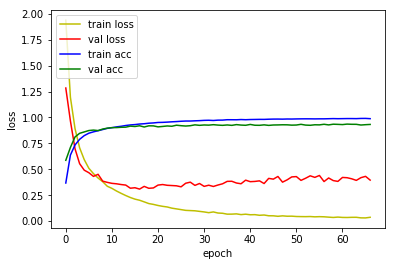

4815/4815 [==============================] - 3s 521us/sample - loss: 0.3842 - acc: 0.8945
Loss: 0.3841953727686517 Accuracy: 0.8944964

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8302 - acc: 0.4015
Epoch 00001: val_loss improved from inf to 1.11043, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_DO_checkpoint/001-1.1104.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.8301 - acc: 0.4015 - val_loss: 1.1104 - val_acc: 0.6490
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9870 - acc: 0.6906
Epoch 00002: val_loss improved from 1.11043 to 0.79558, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_DO_checkpoint/002-0.7956.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.9870 - acc: 0.6906 - val_loss: 0.7956 - val_acc: 0.7570
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0783 - acc: 0.9740
Epoch 00025: val_loss did not improve from 0.16445
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0783 - acc: 0.9740 - val_loss: 0.2022 - val_acc: 0.9478
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0657 - acc: 0.9774
Epoch 00026: val_loss did not improve from 0.16445
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0657 - acc: 0.9774 - val_loss: 0.1861 - val_acc: 0.9571
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9780
Epoch 00027: val_loss did not improve from 0.16445
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0651 - acc: 0.9780 - val_loss: 0.2001 - val_acc: 0.9529
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0625 - acc: 0.9783
Epoch 00028: val_loss did not improve from 0.16445
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9915
Epoch 00055: val_loss did not improve from 0.16445
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0256 - acc: 0.9916 - val_loss: 0.2198 - val_acc: 0.9578
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9914
Epoch 00056: val_loss did not improve from 0.16445
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0257 - acc: 0.9914 - val_loss: 0.2496 - val_acc: 0.9578
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9903
Epoch 00057: val_loss did not improve from 0.16445
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0291 - acc: 0.9903 - val_loss: 0.2087 - val_acc: 0.9562
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9924
Epoch 00058: val_loss did not improve from 0.16445
36805/36805 [===========

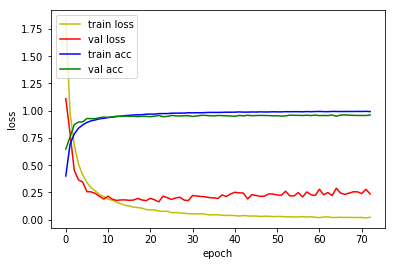

4815/4815 [==============================] - 3s 541us/sample - loss: 0.2263 - acc: 0.9408
Loss: 0.22629101797242032 Accuracy: 0.94080997

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8144 - acc: 0.4010
Epoch 00001: val_loss improved from inf to 0.99514, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_DO_checkpoint/001-0.9951.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.8143 - acc: 0.4011 - val_loss: 0.9951 - val_acc: 0.6681
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8887 - acc: 0.7138
Epoch 00002: val_loss improved from 0.99514 to 0.55646, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_DO_checkpoint/002-0.5565.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8888 - acc: 0.7137 - val_loss: 0.5565 - val_acc: 0.8241
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9931
Epoch 00056: val_loss did not improve from 0.15173
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0232 - acc: 0.9931 - val_loss: 0.2159 - val_acc: 0.9625
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9931
Epoch 00057: val_loss did not improve from 0.15173
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0232 - acc: 0.9931 - val_loss: 0.2274 - val_acc: 0.9634
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9936
Epoch 00058: val_loss did not improve from 0.15173
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0210 - acc: 0.9936 - val_loss: 0.2407 - val_acc: 0.9616
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9945
Epoch 00059: val_loss did not improve from 0.15173
36805/36805 [===========

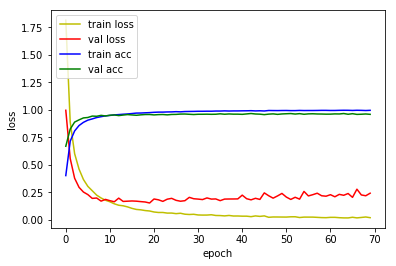

4815/4815 [==============================] - 3s 588us/sample - loss: 0.2229 - acc: 0.9412
Loss: 0.22292777914882697 Accuracy: 0.94122535



In [10]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_64_DO'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_64_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_64_DO'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_64_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 340864)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 340864)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                5453840   
Total params: 5,455,504
Trainable params: 5,455,504
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 365us/sample - loss: 1.5735 - acc: 0.4962


4815/4815 [==============================] - 3s 574us/sample - loss: 0.2263 - acc: 0.9408
Loss: 0.22629101797242032 Accuracy: 0.94080997

1D_CNN_6_only_conv_pool_3_ch_64_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 5302, 64)          102464    
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1768, 64)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 1744, 128)         204928    
_________________________________________________________________
max_pooling1d_38 (MaxPooling 

In [12]:
def build_1d_cnn_only_conv_pool_3_ch_64_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=64, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=64*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [13]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_64_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15976, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 15976, 64)         0         
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 340864)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                5453840   
Total params: 5,455,760
Trainable params: 5,455,632
Non-trainable params: 128
________________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_15 (B (None, 15976, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 15976, 64)         0         
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 5302, 64)          102464    
_________________________________________________________________
batch_normalization_v1_16 (B (None, 5302, 64)          256       
_________________________________________________________________
activation_16 (Activation)   (None, 5302, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3225 - acc: 0.3614
Epoch 00001: val_loss improved from inf to 1.77904, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_64_BN_checkpoint/001-1.7790.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 2.3223 - acc: 0.3614 - val_loss: 1.7790 - val_acc: 0.4477
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2666 - acc: 0.6082
Epoch 00002: val_loss did not improve from 1.77904
36805/36805 [==============================] - 36s 981us/sample - loss: 1.2667 - acc: 0.6082 - val_loss: 1.8525 - val_acc: 0.4957
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9220 - acc: 0.7112
Epoch 00003: val_loss did not improve from 1.77904
36805/36805 [==============================] - 36s 979us/sample - loss: 0.9219 - acc: 0.7112 - val_loss: 2.0670 - val_acc: 0.4594
Epoch 4/500
36800/36805 [=

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0921 - acc: 0.9794
Epoch 00030: val_loss did not improve from 1.77904
36805/36805 [==============================] - 36s 971us/sample - loss: 0.0921 - acc: 0.9794 - val_loss: 4.1519 - val_acc: 0.4987
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0949 - acc: 0.9795
Epoch 00031: val_loss did not improve from 1.77904
36805/36805 [==============================] - 36s 978us/sample - loss: 0.0949 - acc: 0.9795 - val_loss: 3.9609 - val_acc: 0.5045
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0859 - acc: 0.9812
Epoch 00032: val_loss did not improve from 1.77904
36805/36805 [==============================] - 36s 976us/sample - loss: 0.0859 - acc: 0.9812 - val_loss: 4.1184 - val_acc: 0.4908
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0699 - acc: 0.9861
Epoch 00033: val_loss did not improve from 1.77904
36805/36805 [=====

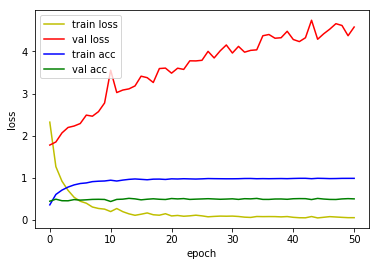

4815/4815 [==============================] - 2s 516us/sample - loss: 1.8347 - acc: 0.4220
Loss: 1.8347309495058386 Accuracy: 0.42201453

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9216 - acc: 0.4187
Epoch 00001: val_loss improved from inf to 2.24284, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_BN_checkpoint/001-2.2428.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 1.9219 - acc: 0.4187 - val_loss: 2.2428 - val_acc: 0.3496
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1911 - acc: 0.6282
Epoch 00002: val_loss improved from 2.24284 to 1.41295, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_BN_checkpoint/002-1.4130.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 1.1911 - acc: 0.6282 - val_loss: 1.4130 - val_acc: 0.5754
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9891
Epoch 00029: val_loss did not improve from 1.30436
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0440 - acc: 0.9891 - val_loss: 2.3218 - val_acc: 0.6399
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0393 - acc: 0.9916
Epoch 00030: val_loss did not improve from 1.30436
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0393 - acc: 0.9916 - val_loss: 3.6756 - val_acc: 0.5201
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0811 - acc: 0.9758
Epoch 00031: val_loss did not improve from 1.30436
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0811 - acc: 0.9758 - val_loss: 2.7373 - val_acc: 0.5826
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9912
Epoch 00032: val_loss did not improve from 1.30436
36805/36805 [===========

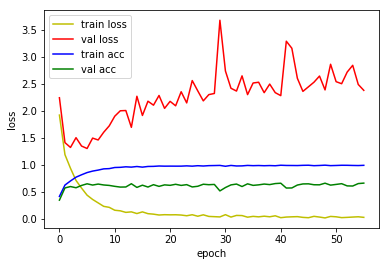

4815/4815 [==============================] - 3s 665us/sample - loss: 1.4473 - acc: 0.6131
Loss: 1.4473364006816907 Accuracy: 0.61308414

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6613 - acc: 0.4975
Epoch 00001: val_loss improved from inf to 1.51248, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_BN_checkpoint/001-1.5125.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 1.6614 - acc: 0.4975 - val_loss: 1.5125 - val_acc: 0.5057
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0440 - acc: 0.6868
Epoch 00002: val_loss improved from 1.51248 to 1.24826, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_BN_checkpoint/002-1.2483.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 1.0439 - acc: 0.6869 - val_loss: 1.2483 - val_acc: 0.6238
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9932
Epoch 00028: val_loss did not improve from 0.76109
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0324 - acc: 0.9932 - val_loss: 1.8500 - val_acc: 0.6893
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0671 - acc: 0.9807
Epoch 00029: val_loss did not improve from 0.76109
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0671 - acc: 0.9807 - val_loss: 1.4829 - val_acc: 0.7482
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0678 - acc: 0.9803
Epoch 00030: val_loss did not improve from 0.76109
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0680 - acc: 0.9802 - val_loss: 1.0840 - val_acc: 0.8025
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9912
Epoch 00031: val_loss did not improve from 0.76109
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9876
Epoch 00058: val_loss did not improve from 0.76109
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0450 - acc: 0.9876 - val_loss: 1.3528 - val_acc: 0.7959

1D_CNN_3_only_conv_pool_3_ch_64_BN Model


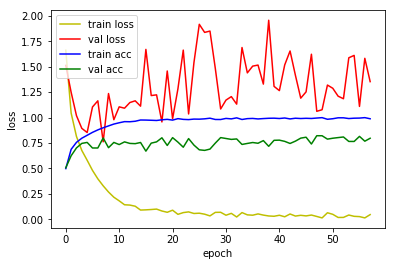

4815/4815 [==============================] - 4s 739us/sample - loss: 0.8598 - acc: 0.7701
Loss: 0.8597982674249113 Accuracy: 0.77009344

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4154 - acc: 0.5564
Epoch 00001: val_loss improved from inf to 1.12500, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_BN_checkpoint/001-1.1250.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.4156 - acc: 0.5564 - val_loss: 1.1250 - val_acc: 0.6632
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8082 - acc: 0.7606
Epoch 00002: val_loss improved from 1.12500 to 0.78600, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_BN_checkpoint/002-0.7860.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.8083 - acc: 0.7605 - val_loss: 0.7860 - val_acc: 0.7699
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9897
Epoch 00027: val_loss did not improve from 0.38360
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0408 - acc: 0.9897 - val_loss: 0.6774 - val_acc: 0.8598
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9912
Epoch 00028: val_loss did not improve from 0.38360
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0343 - acc: 0.9912 - val_loss: 0.4751 - val_acc: 0.8928
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9898
Epoch 00029: val_loss did not improve from 0.38360
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0388 - acc: 0.9898 - val_loss: 0.4388 - val_acc: 0.8961
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9915
Epoch 00030: val_loss did not improve from 0.38360
36805/36805 [===========


1D_CNN_4_only_conv_pool_3_ch_64_BN Model


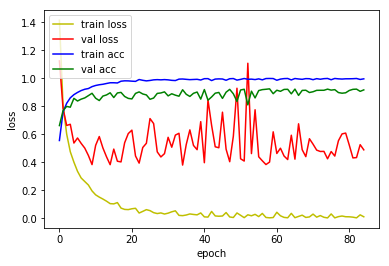

4815/4815 [==============================] - 4s 791us/sample - loss: 0.4765 - acc: 0.8947
Loss: 0.47646708987954994 Accuracy: 0.89470404

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2238 - acc: 0.6218
Epoch 00001: val_loss improved from inf to 1.12438, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_BN_checkpoint/001-1.1244.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.2237 - acc: 0.6219 - val_loss: 1.1244 - val_acc: 0.6313
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5224 - acc: 0.8487
Epoch 00002: val_loss improved from 1.12438 to 0.52651, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_BN_checkpoint/002-0.5265.hdf5
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.5225 - acc: 0.8487 - val_loss: 0.5265 - val_acc: 0.8407
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9952
Epoch 00057: val_loss did not improve from 0.19036
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0158 - acc: 0.9952 - val_loss: 0.2412 - val_acc: 0.9515
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9985
Epoch 00058: val_loss did not improve from 0.19036
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0060 - acc: 0.9985 - val_loss: 0.2207 - val_acc: 0.9567
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9990
Epoch 00059: val_loss did not improve from 0.19036
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0045 - acc: 0.9990 - val_loss: 0.2100 - val_acc: 0.9553
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9939
Epoch 00060: val_loss did not improve from 0.19036
36805/36805 [===========

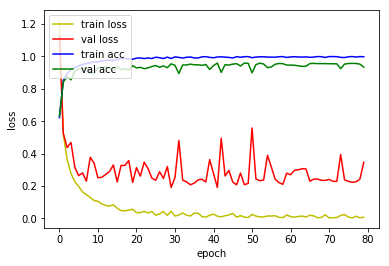

4815/4815 [==============================] - 4s 859us/sample - loss: 0.2440 - acc: 0.9387
Loss: 0.2440456026803358 Accuracy: 0.9387331

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0421 - acc: 0.6839
Epoch 00001: val_loss improved from inf to 0.91600, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_BN_checkpoint/001-0.9160.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 1.0421 - acc: 0.6839 - val_loss: 0.9160 - val_acc: 0.7207
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4206 - acc: 0.8736
Epoch 00002: val_loss improved from 0.91600 to 0.33681, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_BN_checkpoint/002-0.3368.hdf5
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.4206 - acc: 0.8736 - val_loss: 0.3368 - val_acc: 0.8984
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0161 - acc: 0.9954
Epoch 00057: val_loss did not improve from 0.13957
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0161 - acc: 0.9954 - val_loss: 0.1562 - val_acc: 0.9611
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.9992
Epoch 00058: val_loss did not improve from 0.13957
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0036 - acc: 0.9992 - val_loss: 0.1450 - val_acc: 0.9644
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0067 - acc: 0.9982
Epoch 00059: val_loss did not improve from 0.13957
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0067 - acc: 0.9982 - val_loss: 0.2487 - val_acc: 0.9420
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9972
Epoch 00060: val_loss did not improve from 0.13957
36805/36805 [===========

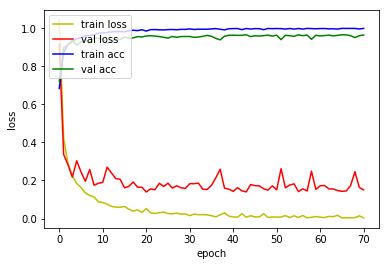

4815/4815 [==============================] - 4s 901us/sample - loss: 0.1670 - acc: 0.9570
Loss: 0.16700085595729813 Accuracy: 0.9570094



In [14]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_64_BN'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_64_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_64_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_64_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_21 (B (None, 15976, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 15976, 64)         0         
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 340864)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                5453840   
Total params: 5,455,760
Trainable params: 5,455,632
Non-trainable params: 128
______________________

4815/4815 [==============================] - 4s 906us/sample - loss: 0.4765 - acc: 0.8947
Loss: 0.47646708987954994 Accuracy: 0.89470404

1D_CNN_5_only_conv_pool_3_ch_64_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_31 (B (None, 15976, 64)         256       
_________________________________________________________________
activation_31 (Activation)   (None, 15976, 64)         0         
_________________________________________________________________
max_pooling1d_73 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 5302, 64)          102464    
_________________________________________________________________
batch_normalization_v1_32 (B 

In [16]:
def build_1d_cnn_only_conv_pool_3_ch_64_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=64, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=64*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [17]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_64_DO_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_84 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_42 (B (None, 15976, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 15976, 64)         0         
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 340864)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 340864)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                5453840   
Total para

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_94 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_52 (B (None, 15976, 64)         256       
_________________________________________________________________
activation_52 (Activation)   (None, 15976, 64)         0         
_________________________________________________________________
max_pooling1d_94 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 5302, 64)          102464    
_________________________________________________________________
batch_normalization_v1_53 (B (None, 5302, 64)          256       
_________________________________________________________________
activation_53 (Activation)   (None, 5302, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2949 - acc: 0.3457
Epoch 00001: val_loss improved from inf to 1.74797, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-1.7480.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 2.2949 - acc: 0.3456 - val_loss: 1.7480 - val_acc: 0.4451
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3236 - acc: 0.5877
Epoch 00002: val_loss improved from 1.74797 to 1.69644, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-1.6964.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.3236 - acc: 0.5877 - val_loss: 1.6964 - val_acc: 0.4957
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0206 - acc: 0.6763
Epoch 00003: val_loss did not improve from 1.69644
36805/36805 [==============================] - 38s 1

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1456 - acc: 0.9603
Epoch 00030: val_loss did not improve from 1.69644
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1456 - acc: 0.9603 - val_loss: 3.5669 - val_acc: 0.5027
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1340 - acc: 0.9629
Epoch 00031: val_loss did not improve from 1.69644
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1340 - acc: 0.9629 - val_loss: 3.3922 - val_acc: 0.5141
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1396 - acc: 0.9613
Epoch 00032: val_loss did not improve from 1.69644
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1396 - acc: 0.9613 - val_loss: 3.5154 - val_acc: 0.5094
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1327 - acc: 0.9654
Epoch 00033: val_loss did not improve from 1.69644
36805/36805 [===========

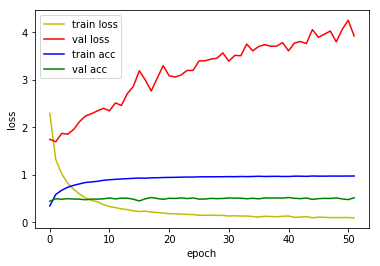

4815/4815 [==============================] - 3s 703us/sample - loss: 1.9298 - acc: 0.4469
Loss: 1.9297522532977047 Accuracy: 0.44693667

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1611 - acc: 0.3721
Epoch 00001: val_loss improved from inf to 1.77438, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-1.7744.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 2.1611 - acc: 0.3721 - val_loss: 1.7744 - val_acc: 0.4333
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4319 - acc: 0.5633
Epoch 00002: val_loss improved from 1.77438 to 1.46297, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-1.4630.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 1.4318 - acc: 0.5633 - val_loss: 1.4630 - val_acc: 0.5565
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0697 - acc: 0.9787
Epoch 00058: val_loss did not improve from 1.18463
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0697 - acc: 0.9787 - val_loss: 1.8576 - val_acc: 0.6914
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0665 - acc: 0.9811
Epoch 00059: val_loss did not improve from 1.18463
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0665 - acc: 0.9811 - val_loss: 1.8212 - val_acc: 0.7051

1D_CNN_2_only_conv_pool_3_ch_64_DO_BN Model


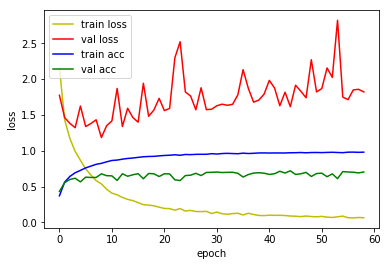

4815/4815 [==============================] - 4s 853us/sample - loss: 1.3267 - acc: 0.6361
Loss: 1.3267017689201814 Accuracy: 0.63613707

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9537 - acc: 0.4186
Epoch 00001: val_loss improved from inf to 1.61063, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-1.6106.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.9536 - acc: 0.4186 - val_loss: 1.6106 - val_acc: 0.4684
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2288 - acc: 0.6274
Epoch 00002: val_loss improved from 1.61063 to 1.04747, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-1.0475.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 1.2290 - acc: 0.6274 - val_loss: 1.0475 - val_acc: 0.6851
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1286 - acc: 0.9573
Epoch 00026: val_loss did not improve from 0.69109
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.1286 - acc: 0.9573 - val_loss: 0.8614 - val_acc: 0.8195
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1285 - acc: 0.9580
Epoch 00027: val_loss did not improve from 0.69109
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.1284 - acc: 0.9580 - val_loss: 0.8376 - val_acc: 0.8230
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1171 - acc: 0.9621
Epoch 00028: val_loss did not improve from 0.69109
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.1171 - acc: 0.9621 - val_loss: 0.8089 - val_acc: 0.8360
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1104 - acc: 0.9624
Epoch 00029: val_loss did not improve from 0.69109
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0559 - acc: 0.9839
Epoch 00056: val_loss did not improve from 0.69109
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0560 - acc: 0.9839 - val_loss: 0.9627 - val_acc: 0.8309
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9821
Epoch 00057: val_loss did not improve from 0.69109
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0586 - acc: 0.9821 - val_loss: 0.9963 - val_acc: 0.8174
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9853
Epoch 00058: val_loss did not improve from 0.69109
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0499 - acc: 0.9853 - val_loss: 1.1820 - val_acc: 0.7992
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0658 - acc: 0.9805
Epoch 00059: val_loss did not improve from 0.69109
36805/36805 [===========

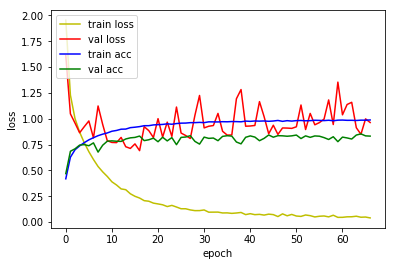

4815/4815 [==============================] - 5s 951us/sample - loss: 0.7914 - acc: 0.7965
Loss: 0.7914211490815303 Accuracy: 0.7964694

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8875 - acc: 0.4302
Epoch 00001: val_loss improved from inf to 1.41882, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-1.4188.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 1.8875 - acc: 0.4302 - val_loss: 1.4188 - val_acc: 0.5453
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0463 - acc: 0.6779
Epoch 00002: val_loss improved from 1.41882 to 0.74161, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-0.7416.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 1.0465 - acc: 0.6779 - val_loss: 0.7416 - val_acc: 0.7806
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1393 - acc: 0.9563
Epoch 00026: val_loss did not improve from 0.37484
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.1394 - acc: 0.9563 - val_loss: 0.4283 - val_acc: 0.9001
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1079 - acc: 0.9650
Epoch 00027: val_loss did not improve from 0.37484
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.1079 - acc: 0.9650 - val_loss: 0.5390 - val_acc: 0.8842
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1026 - acc: 0.9662
Epoch 00028: val_loss did not improve from 0.37484
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.1027 - acc: 0.9661 - val_loss: 0.4068 - val_acc: 0.9022
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1058 - acc: 0.9662
Epoch 00029: val_loss improved from 0.37484 to 0.35984, saving model to mod

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0418 - acc: 0.9862
Epoch 00055: val_loss did not improve from 0.32824
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.0418 - acc: 0.9863 - val_loss: 0.5057 - val_acc: 0.9026
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9851
Epoch 00056: val_loss did not improve from 0.32824
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.0466 - acc: 0.9851 - val_loss: 0.4006 - val_acc: 0.9201
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9851
Epoch 00057: val_loss did not improve from 0.32824
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0467 - acc: 0.9851 - val_loss: 0.5059 - val_acc: 0.9066
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9854
Epoch 00058: val_loss did not improve from 0.32824
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9930
Epoch 00085: val_loss did not improve from 0.32824
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.0236 - acc: 0.9930 - val_loss: 0.6407 - val_acc: 0.8905
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9928
Epoch 00086: val_loss did not improve from 0.32824
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.0271 - acc: 0.9928 - val_loss: 0.4119 - val_acc: 0.9229
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9918
Epoch 00087: val_loss did not improve from 0.32824
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.0262 - acc: 0.9918 - val_loss: 0.3749 - val_acc: 0.9301
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9914
Epoch 00088: val_loss did not improve from 0.32824
36805/36805 [===========

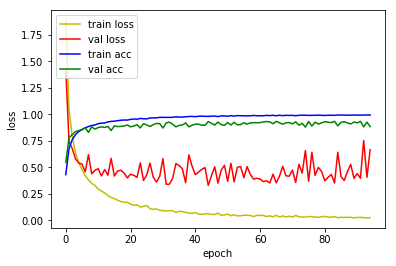

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4321 - acc: 0.9030
Loss: 0.43212774332732673 Accuracy: 0.90301144

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6911 - acc: 0.4788
Epoch 00001: val_loss improved from inf to 1.17257, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-1.1726.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.6909 - acc: 0.4788 - val_loss: 1.1726 - val_acc: 0.6210
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8019 - acc: 0.7556
Epoch 00002: val_loss improved from 1.17257 to 0.95967, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-0.9597.hdf5
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.8018 - acc: 0.7555 - val_loss: 0.9597 - val_acc: 0.7167
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0628 - acc: 0.9790
Epoch 00027: val_loss did not improve from 0.17729
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0633 - acc: 0.9789 - val_loss: 0.2408 - val_acc: 0.9364
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0858 - acc: 0.9718
Epoch 00028: val_loss did not improve from 0.17729
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0859 - acc: 0.9718 - val_loss: 0.1869 - val_acc: 0.9539
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0607 - acc: 0.9802
Epoch 00029: val_loss did not improve from 0.17729
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0608 - acc: 0.9802 - val_loss: 0.2292 - val_acc: 0.9376
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0644 - acc: 0.9789
Epoch 00030: val_loss did not improve from 0.17729
36805/36805 [===========

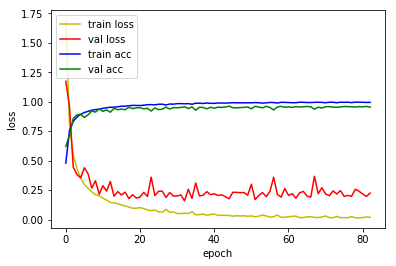

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2348 - acc: 0.9466
Loss: 0.23483234484112306 Accuracy: 0.9466251

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5202 - acc: 0.5323
Epoch 00001: val_loss improved from inf to 1.00084, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-1.0008.hdf5
36805/36805 [==============================] - 115s 3ms/sample - loss: 1.5202 - acc: 0.5323 - val_loss: 1.0008 - val_acc: 0.6958
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6508 - acc: 0.7993
Epoch 00002: val_loss improved from 1.00084 to 0.45130, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-0.4513.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.6508 - acc: 0.7992 - val_loss: 0.4513 - val_acc: 0.8654
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0674 - acc: 0.9792
Epoch 00027: val_loss did not improve from 0.13300
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0674 - acc: 0.9792 - val_loss: 0.1349 - val_acc: 0.9646
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9842
Epoch 00028: val_loss did not improve from 0.13300
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0518 - acc: 0.9842 - val_loss: 0.1755 - val_acc: 0.9525
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9829
Epoch 00029: val_loss did not improve from 0.13300
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0535 - acc: 0.9829 - val_loss: 0.1727 - val_acc: 0.9543
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9853
Epoch 00030: val_loss did not improve from 0.13300
36805/36805 [===========

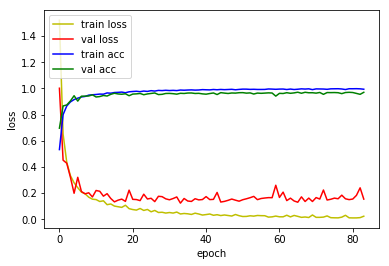

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1878 - acc: 0.9479
Loss: 0.1877937626615863 Accuracy: 0.9478712



In [18]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_64_DO_BN'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_64_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [19]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_64_DO_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_64_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_105 (Conv1D)          (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_63 (B (None, 15976, 64)         256       
_________________________________________________________________
activation_63 (Activation)   (None, 15976, 64)         0         
_________________________________________________________________
max_pooling1d_105 (MaxPoolin (None, 5326, 64)          0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 340864)            0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 340864)            0         
_________________________________________________________________
dense_30 (Dense)             (N

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4321 - acc: 0.9030
Loss: 0.43212774332732673 Accuracy: 0.90301144

1D_CNN_5_only_conv_pool_3_ch_64_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_115 (Conv1D)          (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_73 (B (None, 15976, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 15976, 64)         0         
_________________________________________________________________
max_pooling1d_115 (MaxPoolin (None, 5326, 64)          0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 5302, 64)          102464    
_________________________________________________________________
batch_normalization_v1_74 (B

In [20]:
def build_1d_cnn_only_conv_pool_3_ch_64_BN_2(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=64, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=64*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.0903 - acc: 0.3240
Epoch 00001: val_loss improved from inf to 3.75205, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_64_BN_2_checkpoint/001-3.7520.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 5.0902 - acc: 0.3240 - val_loss: 3.7520 - val_acc: 0.3788
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6149 - acc: 0.5360
Epoch 00002: val_loss did not improve from 3.75205
36805/36805 [==============================] - 40s 1ms/sample - loss: 3.6159 - acc: 0.5360 - val_loss: 4.5882 - val_acc: 0.4447
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0154 - acc: 0.6202
Epoch 00003: val_loss did not improve from 3.75205
36805/36805 [==============================] - 40s 1ms/sample - loss: 3.0157 - acc: 0.6201 - val_loss: 5.0700 - val_acc: 0.4300
Epoch 4/500
36800/36805 [===

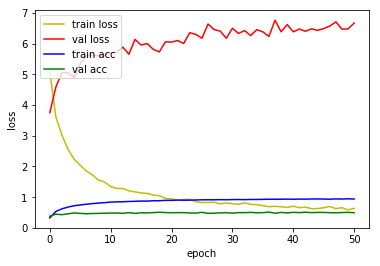

4815/4815 [==============================] - 4s 931us/sample - loss: 3.9263 - acc: 0.3601
Loss: 3.9263386157938007 Accuracy: 0.36012462

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2730 - acc: 0.4485
Epoch 00001: val_loss improved from inf to 2.15819, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_BN_2_checkpoint/001-2.1582.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.2733 - acc: 0.4485 - val_loss: 2.1582 - val_acc: 0.4242
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1245 - acc: 0.7009
Epoch 00002: val_loss improved from 2.15819 to 2.07344, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_BN_2_checkpoint/002-2.0734.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 1.1245 - acc: 0.7009 - val_loss: 2.0734 - val_acc: 0.5553
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0567 - acc: 0.9896
Epoch 00029: val_loss did not improve from 1.99507
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0571 - acc: 0.9896 - val_loss: 3.4837 - val_acc: 0.5770
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0773 - acc: 0.9851
Epoch 00030: val_loss did not improve from 1.99507
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0775 - acc: 0.9851 - val_loss: 3.4874 - val_acc: 0.5877
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1051 - acc: 0.9781
Epoch 00031: val_loss did not improve from 1.99507
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1052 - acc: 0.9781 - val_loss: 3.9281 - val_acc: 0.5479
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0711 - acc: 0.9855
Epoch 00032: val_loss did not improve from 1.99507
36805/36805 [===========

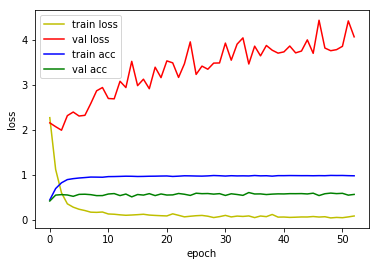

4815/4815 [==============================] - 5s 1ms/sample - loss: 2.0831 - acc: 0.5398
Loss: 2.083073229656041 Accuracy: 0.53977156

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9370 - acc: 0.4929
Epoch 00001: val_loss improved from inf to 1.64599, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_BN_2_checkpoint/001-1.6460.hdf5
36805/36805 [==============================] - 99s 3ms/sample - loss: 1.9370 - acc: 0.4929 - val_loss: 1.6460 - val_acc: 0.5313
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1147 - acc: 0.6996
Epoch 00002: val_loss improved from 1.64599 to 1.50394, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_BN_2_checkpoint/002-1.5039.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.1149 - acc: 0.6995 - val_loss: 1.5039 - val_acc: 0.6322
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0806 - acc: 0.9820
Epoch 00029: val_loss did not improve from 1.44346
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0812 - acc: 0.9819 - val_loss: 2.7954 - val_acc: 0.6261
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0761 - acc: 0.9818
Epoch 00030: val_loss did not improve from 1.44346
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0761 - acc: 0.9818 - val_loss: 2.1589 - val_acc: 0.6925
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9907
Epoch 00031: val_loss did not improve from 1.44346
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0467 - acc: 0.9907 - val_loss: 2.1969 - val_acc: 0.6893
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9879
Epoch 00032: val_loss did not improve from 1.44346
36805/36805 [===========

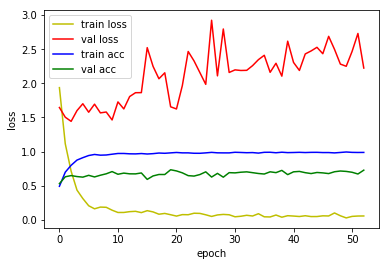

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.5441 - acc: 0.6139
Loss: 1.5441397798395602 Accuracy: 0.61391485

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5641 - acc: 0.5355
Epoch 00001: val_loss improved from inf to 1.68057, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_BN_2_checkpoint/001-1.6806.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.5640 - acc: 0.5355 - val_loss: 1.6806 - val_acc: 0.5118
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9217 - acc: 0.7336
Epoch 00002: val_loss improved from 1.68057 to 0.92012, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_BN_2_checkpoint/002-0.9201.hdf5
36805/36805 [==============================] - 70s 2ms/sample - loss: 0.9218 - acc: 0.7335 - val_loss: 0.9201 - val_acc: 0.7272
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9948
Epoch 00058: val_loss did not improve from 0.54996
36805/36805 [==============================] - 70s 2ms/sample - loss: 0.0244 - acc: 0.9948 - val_loss: 1.1436 - val_acc: 0.8169
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9934
Epoch 00059: val_loss did not improve from 0.54996
36805/36805 [==============================] - 70s 2ms/sample - loss: 0.0269 - acc: 0.9934 - val_loss: 1.1843 - val_acc: 0.7985
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9909
Epoch 00060: val_loss did not improve from 0.54996
36805/36805 [==============================] - 70s 2ms/sample - loss: 0.0353 - acc: 0.9909 - val_loss: 0.7752 - val_acc: 0.8689
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9912
Epoch 00061: val_loss did not improve from 0.54996
36805/36805 [===========

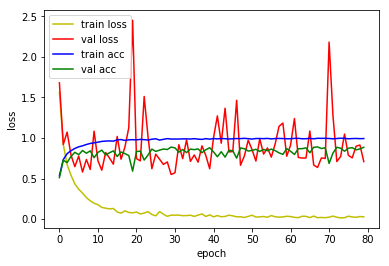

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.6730 - acc: 0.8619
Loss: 0.6729530642584725 Accuracy: 0.8618899

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3024 - acc: 0.6048
Epoch 00001: val_loss improved from inf to 0.97378, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_BN_2_checkpoint/001-0.9738.hdf5
36805/36805 [==============================] - 120s 3ms/sample - loss: 1.3024 - acc: 0.6048 - val_loss: 0.9738 - val_acc: 0.7130
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5929 - acc: 0.8249
Epoch 00002: val_loss improved from 0.97378 to 0.53871, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_BN_2_checkpoint/002-0.5387.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.5929 - acc: 0.8249 - val_loss: 0.5387 - val_acc: 0.8407
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9899
Epoch 00027: val_loss did not improve from 0.22467
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.0341 - acc: 0.9899 - val_loss: 0.2899 - val_acc: 0.9269
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9868
Epoch 00028: val_loss did not improve from 0.22467
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.0457 - acc: 0.9868 - val_loss: 0.2926 - val_acc: 0.9299
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9866
Epoch 00029: val_loss improved from 0.22467 to 0.21935, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_BN_2_checkpoint/029-0.2194.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.0446 - acc: 0.9866 - val_loss: 0.2194 - val_acc: 0.9434
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9909
Epoch 00056: val_loss did not improve from 0.21594
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.0277 - acc: 0.9909 - val_loss: 0.2478 - val_acc: 0.9499
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9928
Epoch 00057: val_loss did not improve from 0.21594
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.0215 - acc: 0.9928 - val_loss: 0.2383 - val_acc: 0.9522
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9941
Epoch 00058: val_loss did not improve from 0.21594
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.0207 - acc: 0.9941 - val_loss: 0.2404 - val_acc: 0.9534
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9980
Epoch 00059: val_loss did not improve from 0.21594
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9961
Epoch 00086: val_loss did not improve from 0.21594
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.0135 - acc: 0.9961 - val_loss: 0.2682 - val_acc: 0.9509
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9978
Epoch 00087: val_loss did not improve from 0.21594
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.0082 - acc: 0.9977 - val_loss: 0.2825 - val_acc: 0.9478
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9947
Epoch 00088: val_loss did not improve from 0.21594
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.0167 - acc: 0.9947 - val_loss: 0.2964 - val_acc: 0.9488
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9977
Epoch 00089: val_loss did not improve from 0.21594
36805/36805 [===========

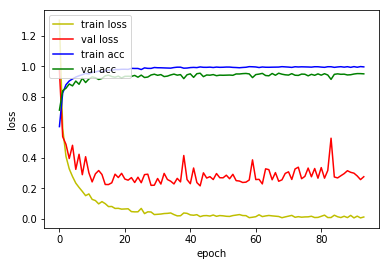

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2884 - acc: 0.9408
Loss: 0.2883980148693359 Accuracy: 0.94080997

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0828 - acc: 0.6632
Epoch 00001: val_loss improved from inf to 0.74901, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_BN_2_checkpoint/001-0.7490.hdf5
36805/36805 [==============================] - 130s 4ms/sample - loss: 1.0827 - acc: 0.6632 - val_loss: 0.7490 - val_acc: 0.7815
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4473 - acc: 0.8639
Epoch 00002: val_loss improved from 0.74901 to 0.35849, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_BN_2_checkpoint/002-0.3585.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.4473 - acc: 0.8639 - val_loss: 0.3585 - val_acc: 0.8894
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9898
Epoch 00028: val_loss improved from 0.14649 to 0.13313, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_BN_2_checkpoint/028-0.1331.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0348 - acc: 0.9898 - val_loss: 0.1331 - val_acc: 0.9648
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9962
Epoch 00029: val_loss did not improve from 0.13313
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0169 - acc: 0.9962 - val_loss: 0.1725 - val_acc: 0.9543
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9948
Epoch 00030: val_loss did not improve from 0.13313
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0197 - acc: 0.9947 - val_loss: 0.1644 - val_acc: 0.9557
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - 

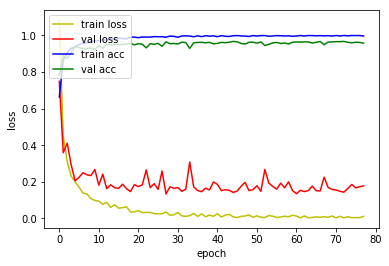

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1873 - acc: 0.9479
Loss: 0.1872522225655685 Accuracy: 0.9478712



In [21]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_64_BN_2'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_64_BN_2(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [23]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_64_BN_2'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_64_BN_2 Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_84 (B (None, 15976, 64)         256       
_________________________________________________________________
activation_84 (Activation)   (None, 15976, 64)         0         
_________________________________________________________________
max_pooling1d_126 (MaxPoolin (None, 5326, 64)          0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 340864)            0         
_________________________________________________________________
batch_normalization_v1_85 (B (None, 340864)            1363456   
_________________________________________________________________
dense_36 (Dense)             (No

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.6730 - acc: 0.8619
Loss: 0.6729530642584725 Accuracy: 0.8618899

1D_CNN_5_only_conv_pool_3_ch_64_BN_2 Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_136 (Conv1D)          (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_98 (B (None, 15976, 64)         256       
_________________________________________________________________
activation_94 (Activation)   (None, 15976, 64)         0         
_________________________________________________________________
max_pooling1d_136 (MaxPoolin (None, 5326, 64)          0         
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 5302, 64)          102464    
_________________________________________________________________
batch_normalization_v1_99 (B (N